# Assignment 9.2 

## Lincoln Brown

### DSC530-T301
### Dr. Parajulee

### Time-Series Analysis

## Exercise 12-1

The linear model I used in this chapter has the obvious drawback that it is linear, and there is no reason to expect prices to change linearly over time. We can add flexibility to the model by adding a quadratic term, as we did in "Nonlinear Relationships" on page 133. 

Use a quadratic model to fit the time series of daily prices, and use the model to generate predictions. You will have to write a vesion of RunLinearModel that runs that quadratic model, but after that you should be able to reuse code in timeseries.py to generate predictions. 

In [19]:
from __future__ import print_function, division

%matplotlib inline

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import numpy as np
import pandas as pd

import random

import thinkstats2
import thinkplot
import statsmodels.formula.api as smf

In [20]:
transactions = pd.read_csv('mj-clean.csv', parse_dates=[5])
transactions.head()

,city,state,price,amount,quality,date,ppg,state.name,lat,lon
0,Annandale,VA,100,7.075,high,2010-09-02,14.13,Virginia,38.830345,-77.213870
1,Auburn,AL,60,28.300,high,2010-09-02,2.12,Alabama,32.578185,-85.472820
2,Austin,TX,60,28.300,medium,2010-09-02,2.12,Texas,30.326374,-97.771258
3,Belleville,IL,400,28.300,high,2010-09-02,14.13,Illinois,38.532311,-89.983521
4,Boone,NC,55,3.540,high,2010-09-02,15.54,North Carolina,36.217052,-81.687983


In [21]:
def GroupByDay(transactions, func=np.mean):
    """Groups transactions by day and compute the daily mean ppg.

    transactions: DataFrame of transactions

    returns: DataFrame of daily prices
    """
    grouped = transactions[['date', 'ppg']].groupby('date')
    daily = grouped.aggregate(func)

    daily['date'] = daily.index
    start = daily.date[0]
    one_year = np.timedelta64(1, 'Y')
    daily['years'] = (daily.date - start) / one_year

    return daily

In [22]:
def GroupByQualityAndDay(transactions):
    """Divides transactions by quality and computes mean daily price.

    transaction: DataFrame of transactions
    
    returns: map from quality to time series of ppg
    """
    groups = transactions.groupby('quality')
    dailies = {}
    for name, group in groups:
        dailies[name] = GroupByDay(group)        

    return dailies


In [23]:
def PlotFittedValues(model, results, label=''):
    """Plots original data and fitted values.

    model: StatsModel model object
    results: StatsModel results object
    """
    years = model.exog[:,1]
    values = model.endog
    thinkplot.Scatter(years, values, s=15, label=label)
    thinkplot.Plot(years, results.fittedvalues, label='model', color='#ff7f00')

In [31]:
def RunLinearModel(daily):
    model = smf.ols('ppg ~ years', data=daily)
    results = model.fit()
    return model, results

In [38]:
def SimulateResults(daily, iters=101, func=RunLinearModel):
    """Run simulations based on resampling residuals.

    daily: DataFrame of daily prices
    iters: number of simulations
    func: function that fits a model to the data

    returns: list of result objects
    """
    _, results = func(daily)
    fake = daily.copy()
    
    result_seq = []
    for _ in range(iters):
        fake.ppg = results.fittedvalues + thinkstats2.Resample(results.resid)
        _, fake_results = func(fake)
        result_seq.append(fake_results)

    return result_seq

In [39]:
def GeneratePredictions(result_seq, years, add_resid=False):
    """Generates an array of predicted values from a list of model results.

    When add_resid is False, predictions represent sampling error only.

    When add_resid is True, they also include residual error (which is
    more relevant to prediction).
    
    result_seq: list of model results
    years: sequence of times (in years) to make predictions for
    add_resid: boolean, whether to add in resampled residuals

    returns: sequence of predictions
    """
    n = len(years)
    d = dict(Intercept=np.ones(n), years=years, years2=years**2)
    predict_df = pd.DataFrame(d)
    
    predict_seq = []
    for fake_results in result_seq:
        predict = fake_results.predict(predict_df)
        if add_resid:
            predict += thinkstats2.Resample(fake_results.resid, n)
        predict_seq.append(predict)

    return predict_seq

In [40]:
def PlotPredictions(daily, years, iters=101, percent=90, func=RunLinearModel):
    """Plots predictions.

    daily: DataFrame of daily prices
    years: sequence of times (in years) to make predictions for
    iters: number of simulations
    percent: what percentile range to show
    func: function that fits a model to the data
    """
    result_seq = SimulateResults(daily, iters=iters, func=func)
    p = (100 - percent) / 2
    percents = p, 100-p

    predict_seq = GeneratePredictions(result_seq, years, add_resid=True)
    low, high = thinkstats2.PercentileRows(predict_seq, percents)
    thinkplot.FillBetween(years, low, high, alpha=0.3, color='gray')

    predict_seq = GeneratePredictions(result_seq, years, add_resid=False)
    low, high = thinkstats2.PercentileRows(predict_seq, percents)
    thinkplot.FillBetween(years, low, high, alpha=0.5, color='gray')

In [41]:
dailies = GroupByQualityAndDay(transactions)
def QuadraticModel(daily):
    daily['years2'] = daily.years**2 
    model = smf.ols('ppg ~ years + years2', data=daily)
    results = model.fit()
    return model, results

In [42]:
#Build model for high quality cannabis to run as a quadratic model to accommodate nonlinear qualities
# of price fluctuations.
name = 'high'
daily = dailies[name]

model, results = QuadraticModel(daily)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ppg   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     517.5
Date:                Sun, 08 Aug 2021   Prob (F-statistic):          4.57e-164
Time:                        13:39:29   Log-Likelihood:                -1497.4
No. Observations:                1241   AIC:                             3001.
Df Residuals:                    1238   BIC:                             3016.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.6980      0.067    205.757      0.000      13.567      13.829
years         -1.1171      0.084    -13.326      0.000      -1.282      -0.953
years2         0.1132      0.022      5.060      0.000       0.069       0.157
==============================================================================
Omnibus:                       49.112   Durbin-Watson:                   1.885
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              113.885
Skew:                           0.199   Prob(JB):                     1.86e-25
Kurtosis:                       4.430   Cond. No.                         27.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Interpretation 
The previous model had an R-squared of .444 and this model has an R-squared of .455, indicating a 1% improvement. This means that the quadratic model uses time as an explanatory variable to account for 45% of the observed variability in price. 
This is also visible in the graph below, where the line curves upward, which is due to the fact that the price per gram is a positive parameter. 

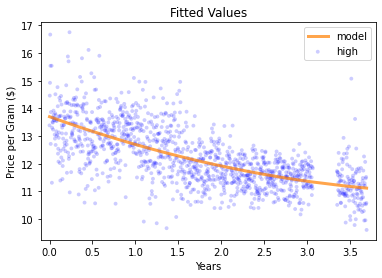

In [43]:
PlotFittedValues(model, results, label=name)
thinkplot.Config(title='Fitted Values',
                 xlabel='Years',
                 xlim=[-0.1, 3.8],
                 ylabel='Price per Gram ($)')

## Predictions
Now that we have a model that we are satisfied with, it is time to begin making predictions. 
We will use the numpy linspace function to create evenly spaced years from 0 to 5. We specify the 101 to make sure they increment by .05 and end exactly on 5. 

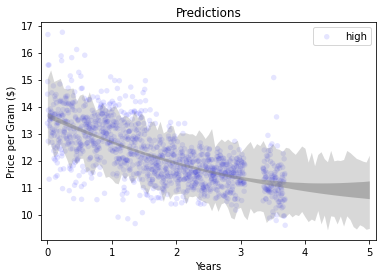

In [49]:
years = np.linspace(0, 5, 101)
thinkplot.Scatter(daily.years, daily.ppg, alpha=0.1, label=name)
PlotPredictions(daily, years, func=QuadraticModel)
thinkplot.Config(title='Predictions',
                 xlabel='Years',
                 xlim=[years[0]-0.1, years[-1]+0.1],
                 ylabel='Price per Gram ($)')

## Interpretation
From the plot above, we can see that the sampling error (dark gray region) grows larger, but the prediction error (lighter gray) stays about the same. The sampling error has more variation towards higher prices, this is due to the nature of a positive quadratic parameter, because as it nears the bottom of the parabola, it will meet more resistance and will not be able to continue a downward trend as it would without a quadratic price paramter. Essentially, the model is explaining that with the limitations of the sample data, there is less certainty about a decline in the price once it approaches ~$11 per gram. 

## Exercise 12-2 

Write a definition for a class named SerialCorrelationTest that extends HypothesisTest from "HypothesisTest' on page 102. It should take a series and a lag as data, compute the serial correlation of the series with the given lag, and then compute the p-value of the observed correlation. 

Use this class to test whether the serial correlation in raw price data is statistically significant. Also test the residuals of the linear model and (if you did the previous exercise), the quadratic model. 

In [56]:
def SerialCorr(series, lag=1):
    xs = series[lag:]
    ys = series.shift(lag)[lag:]
    corr = thinkstats2.Corr(xs, ys)
    return corr

In [57]:
class SerialCorrelationTest(thinkstats2.HypothesisTest):
    """Tests serial correlations by permutation."""

    def TestStatistic(self, data):
        """Computes the test statistic.

        data: tuple of xs and ys
        """
        series, lag = data
        test_stat = abs(SerialCorr(series, lag))
        return test_stat

    def RunModel(self):
        """Run the model of the null hypothesis.

        returns: simulated data
        """
        series, lag = self.data
        permutation = series.reindex(np.random.permutation(series.index))
        return permutation, lag

In [63]:
#Correlation between consecutive prices
name = 'high'
daily = dailies[name]
series = daily.ppg
test = SerialCorrelationTest((series, 1))
pvalue = test.PValue()
print(test.actual, pvalue)

0.4852293761947381 0.0


The correlation between consecutive prices has a test statistic of .48 and a pvalue of 0, indicating that it does have a significant correlation. 

In [60]:
# Serial Correlation in linear model residuals

_, results = RunLinearModel(daily)
series = results.resid
test = SerialCorrelationTest((series, 1))
pvalue = test.PValue()
print(test.actual, pvalue)

0.07570473767506261 0.004


In [62]:
# Serial Correlation in quadratic model residuals

_,  results = QuadraticModel(daily)
series = results.resid
test = SerialCorrelationTest((series, 1))
pvalue = test.PValue()
print(test.actual, pvalue)

0.05607308161289917 0.046


There is no significant correlation in the residuals for the quadratic model, the pvalue is significant on the linear model, but I don't think a test statistic of .07 indicates a strong correlation. 